# Deep Learning Allstar Predictinon Neural Network 

## Imports and Common Functions 

In [1]:
import tensorflow as tf, keras
import pandas as pd, numpy as np, sklearn 
pd.set_option('display.max_columns', None)
import sqlalchemy, sqlite3 
import matplotlib.pyplot as plt 
import os, sys  

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('functions.py'), '..', '..', 'PY')))
import functions  

seasons = functions.generate_seasons(1973, 2024) 

In [2]:
import djangorestframework

ModuleNotFoundError: No module named 'djangorestframework'

In [2]:
def combine_dfs(dfs):
    master = dfs[0]
    for i in range(1, len(dfs)):
        cols_new = dfs[i].columns.difference(master.columns).tolist() 
        cols_new.append('Player') 
        master = pd.merge(master, dfs[i][cols_new], on="Player") 
    return master 

def clean_player(name): 
    i = name.find('*') 
    clean_name = name 
    if i > -1: 
        clean_name = clean_name[:i] 
    return clean_name 


## Dataset/Preprocessing  

In [3]:
db_path = "sqlite:///../../DB/ballbase.db" 

engine = sqlalchemy.create_engine(db_path) 
seasons = functions.generate_seasons(1979, 2024) 
master = pd.DataFrame() 
ssn = pd.DataFrame() 

for season in seasons: 
    master_temp = pd.read_sql("master_" + season, con=engine).drop(['Tm', 'GS', 'Pos'], axis=1).fillna(0) 
    master_temp.insert(1, "Season", [season]*len(master_temp), True) 
    master_temp['Season'] = season.replace('_', '-') 

    master = pd.concat([master, master_temp], axis=0) 

allstars = pd.read_sql('allstars', con=engine) 

master = master if 'AS' in master.columns else master.merge(allstars, how='left', on=['Player', 'Season']) 
master = master.rename(columns = {'Status':'AS'}) 
master['AS'] = master['AS'].apply(lambda x: False if pd.isna(x) else True)
master['AS'] = master['AS'].astype("float64")

numeric_df = master.select_dtypes(include = [np.number]) 
numeric_df 
# master[master['Player']=='LeBron James'] 
master

,Player,Season,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,T2P,T2PA,T3PA,TAST,TBLK,TDRB,TFG,TFGA,TFT,TFTA,TMP,TORB,TPF,TPTS,TSTL,TTOV,TTRB,DRtg,ORtg,3PAr,AST%,BLK%,BPM,DBPM,DRB%,DWS,FTr,OBPM,ORB%,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS
0,Abdul Jeelani,1979-80,25.0,77.0,16.7,3.7,7.3,0.510,0.0,0.1,0.000,3.7,7.3,0.515,0.510,2.1,2.6,0.789,1.5,2.0,3.5,1.2,0.5,0.5,1.5,2.0,9.6,288.0,559.0,6.0,95.0,40.0,156.0,288.0,565.0,161.0,204.0,1286.0,114.0,155.0,737.0,40.0,117.0,270.0,104.0,109.0,0.011,11.6,1.8,1.5,-0.1,13.5,1.5,0.361,1.7,9.6,2.3,18.7,1.5,15.2,11.5,0.563,24.6,1.1,3.8,0.141,0.0
1,Adrian Dantley,1979-80,24.0,68.0,39.3,10.7,18.6,0.576,0.0,0.0,0.000,10.7,18.6,0.577,0.576,6.5,7.7,0.842,2.7,4.9,7.6,2.8,1.4,0.2,3.4,3.1,28.0,730.0,1265.0,2.0,191.0,14.0,333.0,730.0,1267.0,443.0,526.0,2674.0,183.0,211.0,1903.0,96.0,233.0,516.0,110.0,119.0,0.002,12.3,0.3,3.7,-1.6,14.0,1.1,0.415,5.3,8.3,9.5,24.3,1.8,13.5,11.3,0.635,27.8,3.8,10.5,0.189,1.0
2,Al Skinner,1979-80,27.0,2.0,5.0,0.5,1.0,0.500,0.0,0.0,0.000,0.5,1.0,0.500,0.500,0.0,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,1.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,10.0,0.0,1.0,2.0,0.0,2.0,0.0,111.0,65.0,0.000,25.4,0.0,-4.8,-0.2,0.0,0.0,0.000,-4.6,0.0,0.0,-0.6,0.0,50.0,0.0,0.500,16.0,0.0,0.0,-0.152,0.0
3,Alex English,1979-80,26.0,78.0,30.8,7.1,14.3,0.497,0.0,0.1,0.333,7.1,14.2,0.498,0.498,2.7,3.4,0.789,3.4,4.3,7.8,2.9,0.9,0.8,2.7,2.6,16.9,551.0,1107.0,6.0,224.0,62.0,336.0,553.0,1113.0,210.0,266.0,2401.0,269.0,206.0,1318.0,73.0,214.0,605.0,107.0,106.0,0.005,13.9,1.4,0.4,-1.2,14.9,2.0,0.239,1.6,11.3,3.3,18.0,1.4,14.8,13.1,0.536,23.4,1.5,5.3,0.105,0.0
4,Allan Bristow,1979-80,28.0,82.0,28.1,4.6,9.6,0.480,0.0,0.1,0.286,4.6,9.5,0.482,0.482,2.4,3.0,0.811,2.1,4.2,6.2,4.2,1.1,0.1,2.2,2.6,11.6,375.0,778.0,7.0,341.0,6.0,342.0,377.0,785.0,197.0,243.0,2304.0,170.0,211.0,953.0,88.0,179.0,512.0,110.0,108.0,0.009,21.4,0.1,0.6,-0.8,16.7,1.2,0.310,1.4,9.0,3.2,16.6,1.9,16.7,13.0,0.534,20.0,1.5,4.4,0.091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,Zach LaVine,2023-24,28.0,25.0,34.9,6.8,15.0,0.452,2.4,6.8,0.349,4.4,8.3,0.536,0.531,3.5,4.1,0.854,0.3,4.8,5.2,3.9,0.8,0.3,2.1,2.3,19.5,111.0,207.0,169.0,98.0,8.0,121.0,170.0,376.0,88.0,103.0,872.0,8.0,57.0,487.0,21.0,52.0,129.0,118.0,113.0,0.449,16.8,0.9,0.1,-0.7,15.8,0.6,0.274,0.8,1.0,0.8,15.1,1.2,11.0,8.3,0.578,23.8,0.5,1.5,0.080,0.0
19371,Zavier Simpson,2023-24,26.0,7.0,23.0,2.4,7.7,0.315,0.7,2.4,0.294,1.7,5.3,0.324,0.361,0.4,0.6,0.750,0.6,2.3,2.9,3.6,1.0,0.4,1.4,1.6,6.0,12.0,37.0,17.0,25.0,3.0,16.0,17.0,54.0,3.0,4.0,161.0,4.0,11.0,42.0,7.0,10.0,20.0,115.0,86.0,0.315,22.5,1.7,-5.9,0.3,11.3,0.2,0.074,-6.2,2.6,-0.3,6.3,2.1,15.2,6.8,0.377,17.5,-0.2,-0.2,-0.046,0.0
19372,Zeke Nnaji,2023-24,23.0,58.0,9.9,1.2,2.6,0.463,0.1,0.4,0.261,1.1,2.2,0.500,0.483,0.7,1.1,0.677,1.1,1.1,2.2,0.6,0.3,0.7,0.5,1.4,3.2,63.0,126.0,23.0,32.0,38.0,65.0,69.0,149.0,42.0,62.0,576.0,61.0,81.0,186.0,15.0,27.0,126.0,112.0,113.0,0.154,7.0,5.6,-3.7,0.1,12.2,0.8,0.416,-3.8,12.1,0.4,12.4,1.3,13.3,12.1,0.528,15.4,-0.2,1.2,0.099,0.0
19373,Ziaire Williams,2023-24,22.0,51.0,20.4,2.9,7.4,0.397,1.1,3.7,0.307,1.8,3.7,0.487,0.474,1.2,1.5,0.827,0.7,2.8,3.5,1.5,0.7,0.2,1.3,1.7,8.2,92.0,189.0,189.0,75.0,9.0,145.0,150.0,378.0,62.0,75.0,1038.0,35.0,85.0,420.0,36.0,66.0,180.0,115.0,98.0,0.500,11.1,0.8,-4.5,-0.4,15.9,1.1,0.198,-4.0,3.5,-0.9,9.3,1.7,13.8,9.5,0.511,19.7,-0.6,0.2,0.010,0.0


In [4]:
target = numeric_df['AS'] 
numeric_tensor = tf.convert_to_tensor(numeric_df.drop('AS', axis=1) )  
target = tf.convert_to_tensor(target) 
normalizer = tf.keras.layers.Normalization(axis=-1) 
normalizer.adapt(numeric_tensor) 
numeric_tensor

<tf.Tensor: shape=(19375, 64), dtype=float64, numpy=
array([[ 2.50e+01,  7.70e+01,  1.67e+01, ...,  1.10e+00,  3.80e+00,
         1.41e-01],
       [ 2.40e+01,  6.80e+01,  3.93e+01, ...,  3.80e+00,  1.05e+01,
         1.89e-01],
       [ 2.70e+01,  2.00e+00,  5.00e+00, ...,  0.00e+00,  0.00e+00,
        -1.52e-01],
       ...,
       [ 2.30e+01,  5.80e+01,  9.90e+00, ..., -2.00e-01,  1.20e+00,
         9.90e-02],
       [ 2.20e+01,  5.10e+01,  2.04e+01, ..., -6.00e-01,  2.00e-01,
         1.00e-02],
       [ 2.30e+01,  7.00e+01,  3.15e+01, ...,  3.30e+00,  7.50e+00,
         1.64e-01]])>

In [5]:
import sklearn.model_selection 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(numeric_df.drop('AS', axis=1), numeric_df['AS'], test_size=0.2, random_state=1) 

X_train = tf.convert_to_tensor(X_train) 
X_test = tf.convert_to_tensor(X_test) 
y_train = tf.convert_to_tensor(y_train)  
y_test = tf.convert_to_tensor(y_test)  

normalizer = tf.keras.layers.Normalization(axis=-1)  
normalizer.adapt(X_train) 

## Model Creation 

In [6]:

model = keras.Sequential() 
model.add(normalizer) 
model.add(keras.layers.Dense(units=10, activation='relu')) 
model.add(keras.layers.Dense(units=10, activation='relu')) 
model.add(keras.layers.Dense(units=1, activation='sigmoid'))  

# Compile model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.1) 

Epoch 1/10
13950/13950 ━━━━━━━━━━━━━━━━━━━━ 14s 888us/step - accuracy: 0.9382 - loss: 0.1479 - val_accuracy: 0.9716 - val_loss: 0.0677
Epoch 2/10
13950/13950 ━━━━━━━━━━━━━━━━━━━━ 13s 899us/step - accuracy: 0.9665 - loss: 0.0788 - val_accuracy: 0.9735 - val_loss: 0.0704
Epoch 3/10
13950/13950 ━━━━━━━━━━━━━━━━━━━━ 13s 930us/step - accuracy: 0.9681 - loss: 0.0776 - val_accuracy: 0.9703 - val_loss: 0.0633
Epoch 4/10
13950/13950 ━━━━━━━━━━━━━━━━━━━━ 13s 962us/step - accuracy: 0.9679 - loss: 0.0738 - val_accuracy: 0.9748 - val_loss: 0.0568
Epoch 5/10
13950/13950 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9679 - loss: 0.0754 - val_accuracy: 0.9729 - val_loss: 0.0649
Epoch 6/10
13950/13950 ━━━━━━━━━━━━━━━━━━━━ 14s 992us/step - accuracy: 0.9679 - loss: 0.0715 - val_accuracy: 0.9748 - val_loss: 0.0569
Epoch 7/10
13950/13950 ━━━━━━━━━━━━━━━━━━━━ 13s 941us/step - accuracy: 0.9716 - loss: 0.0681 - val_accuracy: 0.9735 - val_loss: 0.0632
Epoch 8/10
13950/13950 ━━━━━━━━━━━━━━━━━━━━ 13s 932us/ste

In [7]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)  
print(f'Test Accuracy: {test_accuracy}') 

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.9687 - loss: 0.0742
Test Accuracy: 0.9685161113739014


## Testing Curves and Visualizations 

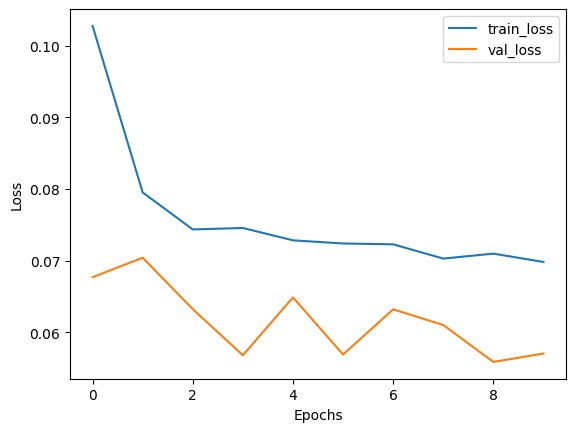

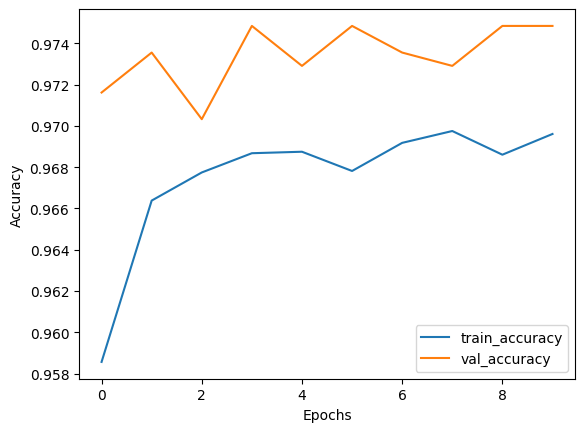

In [8]:
# Plot training history 
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step


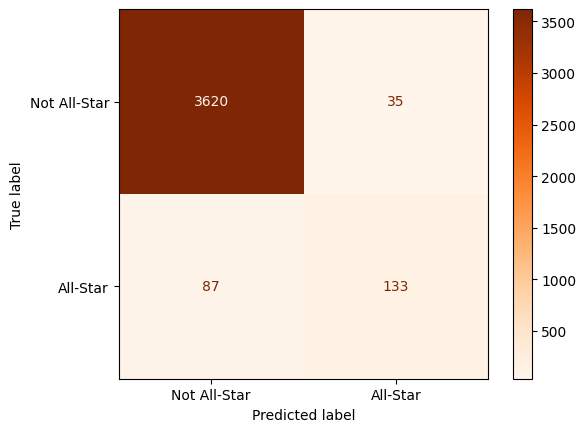

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test) 
predicted_labels = (predictions > 0.5).astype(int) 

cm = confusion_matrix(y_test, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not All-Star', 'All-Star'])
disp.plot(cmap=plt.cm.Oranges)
plt.show()

## Model Demo 

In [10]:
def predict_allstar(player_name, season): 
    player = master[(master['Player']==player_name) & (master['Season'] == season)] 
    if(len(player)<1):  
        return "Player/season not found (spelling error?)","Player/season not found", "Player/season not found" 
    true_label = True if player['AS'].values[0] == 1 else False 
    player = (player.select_dtypes(include=[np.number]) 
              .drop('AS', axis=1) 
              .values 
              .reshape(1, 64)
    )
    player = tf.convert_to_tensor(player) 
    probability = model.predict(player)[0][0]  
    prediction = True if probability > 0.5 else False 

    return prediction, probability, true_label  

In [11]:
# !pip install gradio 
import gradio 

demo = gradio.Interface(
    fn=predict_allstar, 
    inputs=[
        gradio.Textbox(label="Player Full Name(First Last):"), 
        gradio.Textbox(label="Season(YYYY-YY):") 
    ], 
    outputs=[
        gradio.Textbox(label='Model All-Star Prediction:'), 
        gradio.Textbox(label='All-Star Prediction Probability:'), 
        gradio.Textbox(label='Was All-Star:')
    ], 
)
demo.launch() 

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
